In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image  
import time

import torchvision
import torchvision.transforms as transforms
import torchvision.utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from utils import toumap, totsne, plotsmart
from utils import getallranks, calcmap
from utils import bestk_silhouette_score, getclusters_ws

from dataset import CustomDataset, DatasetFeatsTrain, dsbuild
from model import netmodel
from loss import HybridLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print('Using device:', torch.cuda.is_available(), torch.cuda.get_device_name(0))

Using device: True NVIDIA GeForce RTX 4090


# Feature Extraction

**Pre-traineded models**

In [7]:
netfeat = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
netfeat.to(device)
netfeat.eval()

def getfeat(x):
    with torch.no_grad():
        X = netfeat(x)
    return X

Using cache found in /home/de/.cache/torch/hub/facebookresearch_dinov2_main


In [8]:
class ConvertTo3Channels:
    def __call__(self, img):
        # Se a imagem já tiver 3 canais, retorne-a como está
        if img.mode == "RGB":
            return img
        # Caso contrário, converta-a para RGB
        return img.convert("RGB")
    
transform = transforms.Compose(
    [
        ConvertTo3Channels(),
        transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ]
)

def configfeats(ds):
    with torch.no_grad():
        ds.feats = [[getfeat(d.unsqueeze(0).to(device))[0].cpu(), l] for d, l in ds]

train_dataset = dsbuild('/home/de/lab/ds/corel5k', transform=transform)


In [5]:
from sklearn.model_selection import StratifiedKFold

n_folds = 5 # ou seja um quinto (20/80), vai treinar com 20% e validar o resto, mas com todas as partes, retornando 5 resultados, e depois obter uma média
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True)
x, y = [ d for d,_ in train_dataset], train_dataset.targets

crossidxs = [[idxtrain, idxtest] for idxtrain, idxtest in stratified_kfold.split(x, y)]

imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[0][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[0][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[0][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[0][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)
len(ds.data)

/tmp/ipykernel_268608/277675855.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[0][0]]
/tmp/ipykernel_268608/277675855.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[0][1]]


4000

**FOLD 1**

# Clustering and centroid computation

In [ ]:
#xtsne = totsne([f for f, l in ds.feats])
# plotsmart(xtsne, [l for _, l in ds.feats])

**Clustering step**

K score 3 : 0.34275836
K score 4 : 0.32061923
K score 5 : 0.29314286
K score 6 : 0.29046065
K score 7 : 0.30906013
K score 8 : 0.32532957
K score 9 : 0.34741676
K score 10 : 0.36857367
K score 11 : 0.38010272
K score 12 : 0.3890711
K score 13 : 0.40069386
K score 14 : 0.4148597
K score 15 : 0.42119256
K score 16 : 0.42324153
K score 17 : 0.42469728
K score 18 : 0.43825665
K score 19 : 0.4458422
K score 20 : 0.4585575
K score 21 : 0.4644345
K score 22 : 0.47769624
K score 23 : 0.48571995
K score 24 : 0.4945339
K score 25 : 0.49750972
K score 26 : 0.51169664
K score 27 : 0.52542907
K score 28 : 0.5401567
K score 29 : 0.5492716
K score 30 : 0.5560653
K score 31 : 0.5624987
K score 32 : 0.57142955
K score 33 : 0.57913375
K score 34 : 0.5877116
K score 35 : 0.5933089
K score 36 : 0.6004854
K score 37 : 0.60825866
K score 38 : 0.61803937
K score 39 : 0.6261528
K score 40 : 0.62928456
K score 41 : 0.63590276
K score 42 : 0.64330846
K score 43 : 0.6495721
K score 44 : 0.6569735
K score 45 : 0.

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


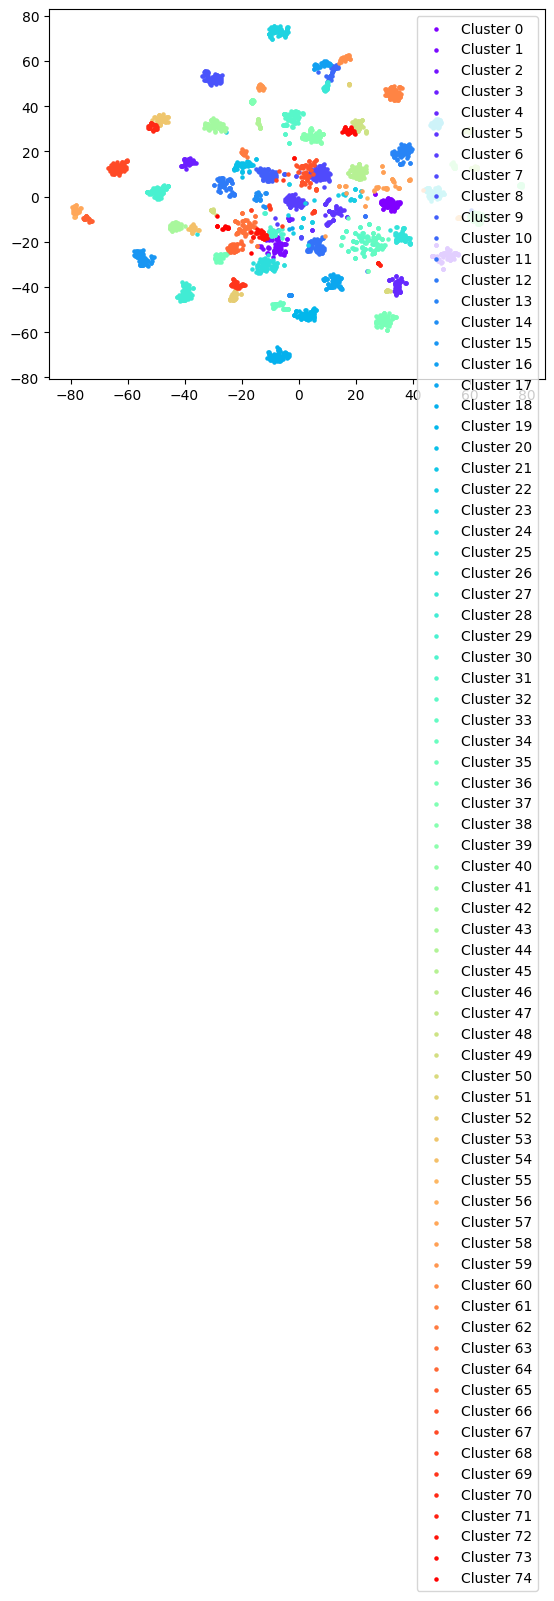

In [30]:
from sklearn.cluster import  AgglomerativeClustering

feats = [f for f,_ in ds.feats]
X = totsne(feats)

sampling_factor = 1 # for fast silhouette_score
idxs_sampling = random.sample(range(len(ds.feats)), round(len(ds.feats) * sampling_factor))
xsampling = totsne([feats[i] for i in idxs_sampling])
nclusters = bestk_silhouette_score(xsampling, rangeend=100) #get_nclusters(feats)

agg = AgglomerativeClustering(n_clusters=nclusters)
clusterlbs = agg.fit_predict(toumap(feats))
plotsmart(X, clusterlbs)

# Teacher neural network model

In [10]:
def getpar(ds):
    idxa = random.randint(0, len(ds.feats)-1)
    anchor, cl = ds.feats[idxa]

    is_same_class = random.choice([True, False])
    if is_same_class:
        pairidx = random.choice(ds.lbclassrel[cl.item()])
    else:
        cls = ds.idclasses.copy()
        cls.remove(cl.item())
        pairidx = random.choice(ds.lbclassrel[random.choice(cls)])
        
    pair_img, clp = ds.feats[pairidx]
    #print(cl, clp)
    mgadd = torch.tensor(ds.clusters_ws[cl.item()][clp.item()])
    return anchor, pair_img, torch.tensor(int(not is_same_class)), cl, clp, mgadd

def getbatch(ds, nbatch=32):
    ret = [getpar(ds) for n in range(nbatch)]
    anchors, pars, lbs, albs, plbs, mgs = [], [], [], [], [], []
    for r in ret:
        anchors.append(r[0])
        pars.append(r[1])
        lbs.append(r[2])
        albs.append(r[3])
        plbs.append(r[4])
        mgs.append(r[5])
    # [r[0] for r in ret], [r[1] for r in ret],[r[2] for r in ret]
    return torch.stack(anchors, dim=0), torch.stack(pars, dim=0), torch.stack(lbs, dim=0), torch.stack(albs, dim=0), torch.stack(plbs, dim=0), torch.stack(mgs, dim=0)

In [11]:

class histloss():
    def __init__(self) -> None:
        self.histloss =[]

hloss = histloss()

def treino(model, ds, n_epochs=1000, _margin = 2.0, _batchsize = 128):

    optimizer = optim.AdamW(model.parameters(), lr=0.0014)
    criterion = HybridLoss(margin=_margin)  # ContrastiveLoss(margin=_margin) 

    model.train()
    lossacum = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        ctd = 0
        start = time.time()

        img1, img2, label, lbs1, lbs2, mgadd = getbatch(ds, _batchsize)
        img1, img2, label, lbs1, lbs2, mgadd = img1.to(device), img2.to(device), label.to(device), lbs1.to(device), lbs2.to(device), mgadd.to(device) 
        optimizer.zero_grad()
        
        #img1, img2 = F.normalize(img1, dim=1), F.normalize(img2, dim=1)
        #print(img1.shape)
        _, outlbs1, ored1 = model(img1)     
        _, outlbs2, ored2 = model(img2)

        outlbs = F.log_softmax(torch.cat([outlbs1, outlbs2]), dim=0)
        rotulos = torch.cat([lbs1, lbs2])

        perda_instantanea = criterion(label, outlbs, rotulos, ored1, ored2, mgadd)  
        #perda_instantanea = criteriosmax(outlbs, rotulos) 
        perda_instantanea.backward()
        optimizer.step()

        running_loss += perda_instantanea.item() # loss_contrastive.item()
        lossacum += running_loss                 
        ctd+=1

        if epoch> 0 :  # print every 10 mini-batches
            print('[%d] loss: %.5f' %
                    (epoch + 1, running_loss / ctd), 'time: ' + str(time.time() - start))
            hloss.histloss.append(running_loss / ctd)
            running_loss = 0.0
            ctd = 0

    print('Finished Training')
    ds.training = False
    return n_epochs, lossacum

In [31]:
import time

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

for idc in dstrain.clusters_ws:
    for idr in dstrain.clusters_ws[idc]:
        dstrain.clusters_ws[idc][idr] = 0

net = netmodel(out_dim=len(dstrain.idclasses)).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

[2] loss: 0.51942 time: 0.1449277400970459
[3] loss: 0.47510 time: 0.1465606689453125
[4] loss: 0.33883 time: 0.14904451370239258
[5] loss: 0.27774 time: 0.15292119979858398
[6] loss: 0.20871 time: 0.1411275863647461
[7] loss: 0.16600 time: 0.1419358253479004
[8] loss: 0.15144 time: 0.14612579345703125
[9] loss: 0.13150 time: 0.14975500106811523
[10] loss: 0.10744 time: 0.14165782928466797
[11] loss: 0.10347 time: 0.13999032974243164
[12] loss: 0.09043 time: 0.1400153636932373
[13] loss: 0.08411 time: 0.14032793045043945
[14] loss: 0.07445 time: 0.1397542953491211
[15] loss: 0.06493 time: 0.1405620574951172
[16] loss: 0.06039 time: 0.144456148147583
[17] loss: 0.05676 time: 0.15140938758850098
[18] loss: 0.05425 time: 0.14922022819519043
[19] loss: 0.04736 time: 0.1539616584777832
[20] loss: 0.04733 time: 0.15357279777526855
[21] loss: 0.04054 time: 0.14435315132141113
[22] loss: 0.04174 time: 0.1464693546295166
[23] loss: 0.04095 time: 0.14499425888061523
[24] loss: 0.03450 time: 0.14

(1000, 11.284119762363844)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


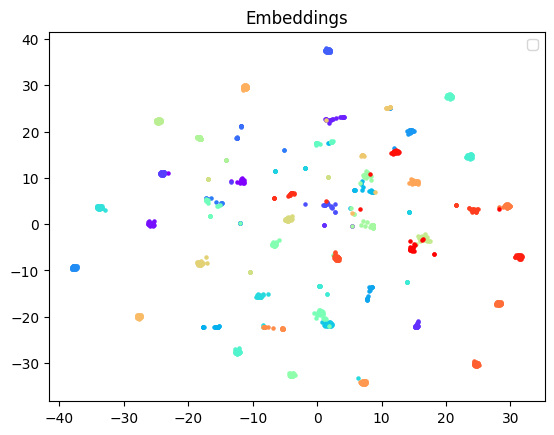

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


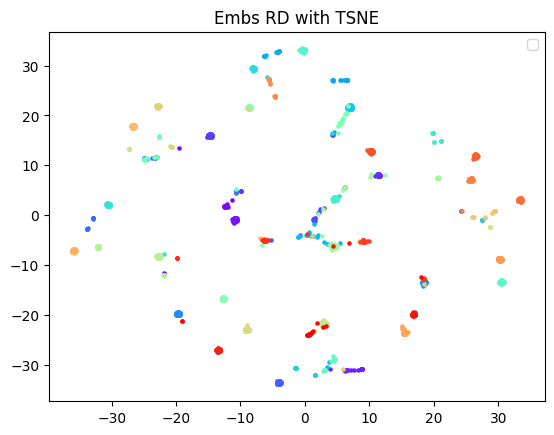

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


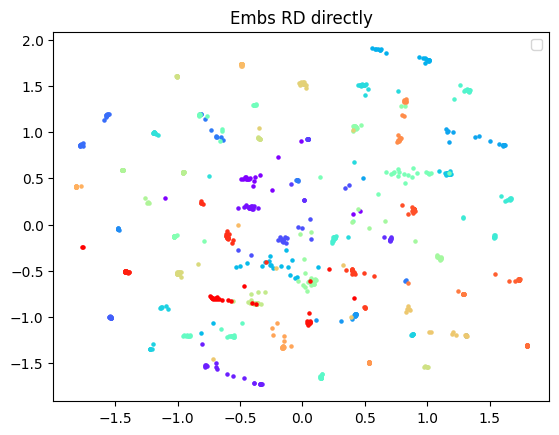

In [32]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

plotsmart(totsne(fsembs), lbs, "Embeddings", True)
plotsmart(totsne(fsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(fsreduc), lbs, "Embs RD directly", True)

In [33]:
res = {}

In [34]:
# print()
print("Método proposto sem margem moderada")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_not_mg'] = [resmap]
resmap

Método proposto sem margem moderada


0.8155317624019319

In [35]:
dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

hloss = histloss()
net = netmodel(out_dim=len(dstrain.idclasses)).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

[2] loss: 0.77295 time: 0.14678668975830078
[3] loss: 0.62479 time: 0.14610719680786133
[4] loss: 0.49364 time: 0.14830780029296875
[5] loss: 0.42876 time: 0.14193367958068848
[6] loss: 0.36126 time: 0.15099287033081055
[7] loss: 0.32603 time: 0.15378761291503906
[8] loss: 0.28492 time: 0.15609359741210938
[9] loss: 0.26332 time: 0.14365482330322266
[10] loss: 0.24409 time: 0.15786337852478027
[11] loss: 0.22896 time: 0.14911699295043945
[12] loss: 0.24160 time: 0.15160179138183594
[13] loss: 0.22091 time: 0.1552138328552246
[14] loss: 0.18830 time: 0.15153932571411133
[15] loss: 0.19840 time: 0.15859532356262207
[16] loss: 0.17725 time: 0.14904379844665527
[17] loss: 0.17870 time: 0.14722275733947754
[18] loss: 0.17637 time: 0.15754413604736328
[19] loss: 0.15781 time: 0.15637946128845215
[20] loss: 0.16139 time: 0.14574718475341797
[21] loss: 0.15851 time: 0.1587531566619873
[22] loss: 0.14364 time: 0.14311742782592773
[23] loss: 0.15491 time: 0.15718841552734375
[24] loss: 0.14319 t

(1000, 56.92848655041306)

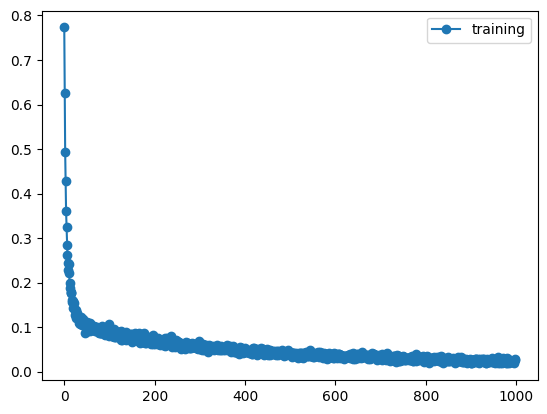

In [36]:
plt.plot(hloss.histloss, 'o-', label='training')
plt.legend()
plt.show()

#validafeats(net, device, [ f for f, _ in ds.feats], [ l for _, l in ds.feats])
#validafeats(net, device, [f for f, _ in dstest.feats], [ l for _, l in dstest.feats])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


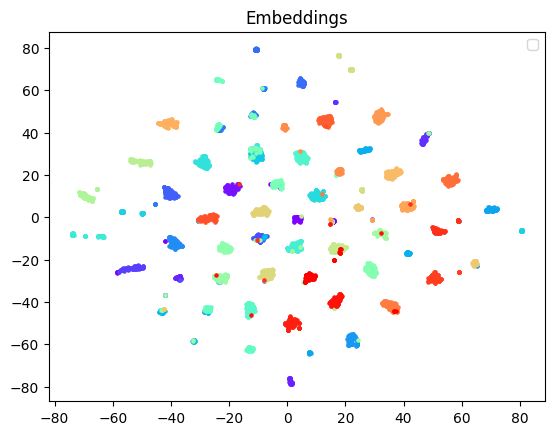

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


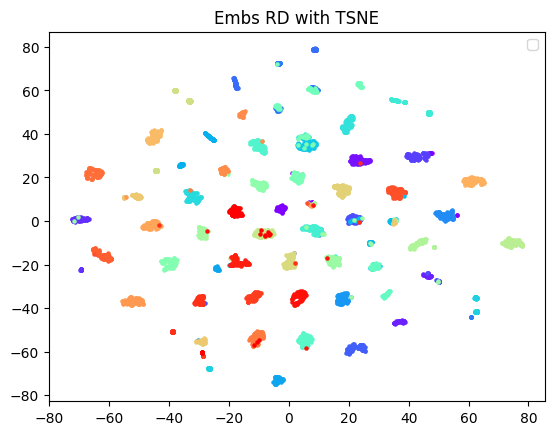

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


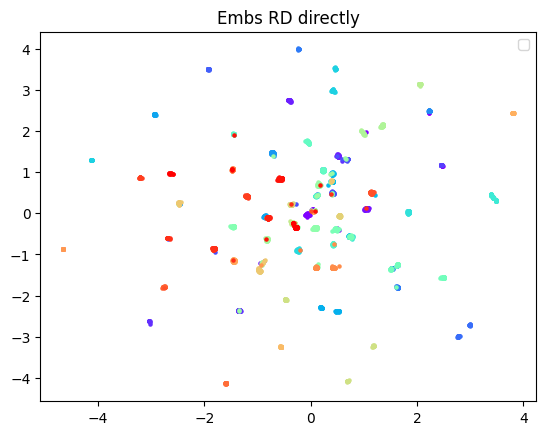

In [37]:
net.eval()
with torch.no_grad():
    trainfs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in ds.feats], [l for f,l in ds.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
trainfsembs, trainfsreduc = [f[0].cpu().squeeze() for f in trainfs], [f[2].cpu().squeeze() for f in trainfs]

plotsmart(totsne(trainfsembs), lbs, "Embeddings", True)
plotsmart(totsne(trainfsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(trainfsreduc), lbs, "Embs RD directly", True)

**TEST Set**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


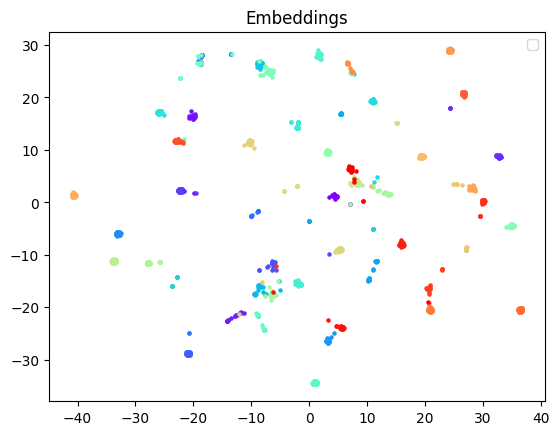

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


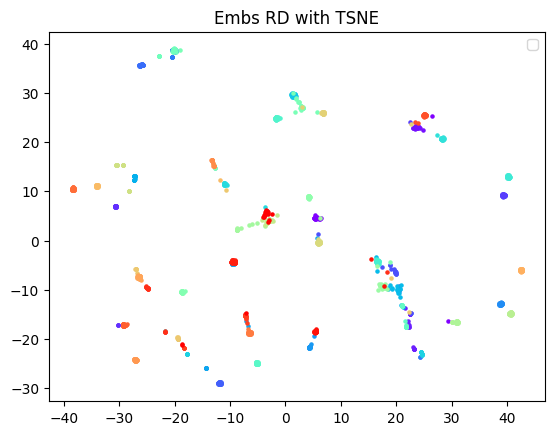

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


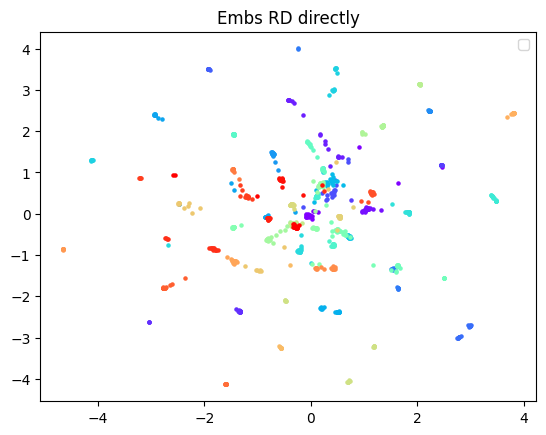

In [38]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

plotsmart(totsne(fsembs), lbs, "Embeddings", True)
plotsmart(totsne(fsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(fsreduc), lbs, "Embs RD directly", True)

In [39]:
# print()
print("Método proposto")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_with_mg'] = [resmap]
resmap

Método proposto


0.8254692576917676

In [40]:
print("Método proposto High Dim")
ranks = getallranks(fsembs)
resmap = calcmap(ranks, lbs)
res['ours_with_mg_highdim'] = [resmap]
resmap

Método proposto High Dim


0.8531751939629234

In [41]:
print("Sem projeção")
X = [f for f,l in dstest.feats]
ranks = getallranks(X)
resmap = calcmap(ranks, lbs)
res['no_projection'] = [resmap]
resmap

Sem projeção


0.7814263812282792

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

print("PCA")
X = [f for f,l in dstest.feats]
X_pca = pca.fit_transform(X)
ranks = getallranks(torch.tensor(X_pca))
resmap = calcmap(ranks, lbs)
res['pca'] = [resmap]
resmap

PCA


0.22548332136525356

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


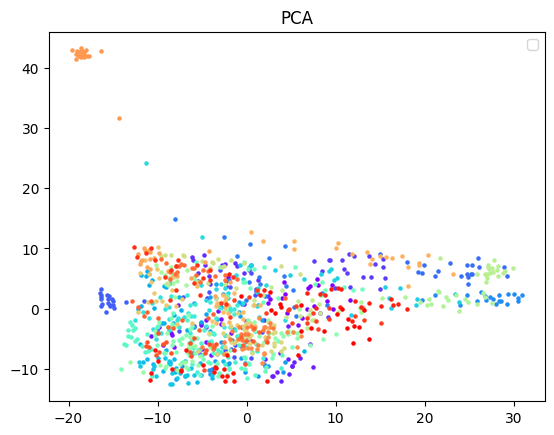

In [43]:
plotsmart(X_pca, lbs, "PCA", True)

In [44]:
print("T-SNE")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(totsne(X)))
resmap = calcmap(ranks, lbs)
res['tsne'] = [resmap]
resmap

T-SNE


0.8582389088541559

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


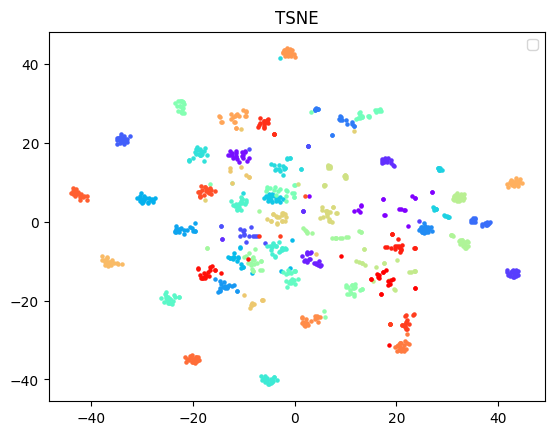

In [45]:
plotsmart(totsne(X), lbs, "TSNE", True)

In [46]:
print("UMAP")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(toumap(X)))
resmap = calcmap(ranks, lbs)
res['umap'] = [resmap]
resmap

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP


0.8529363279132681

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


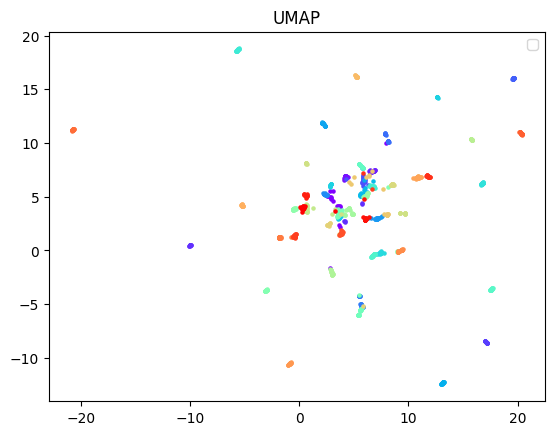

In [47]:
plotsmart(toumap(X), lbs, "UMAP", True)

In [48]:
res

{'ours_not_mg': [0.8155317624019319],
 'ours_with_mg': [0.8254692576917676],
 'ours_with_mg_highdim': [0.8531751939629234],
 'no_projection': [0.7814263812282792],
 'pca': [0.22548332136525356],
 'tsne': [0.8582389088541559],
 'umap': [0.8529363279132681]}

**FOLD 2**

In [49]:
idfold = 1 # = Fold 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

agg = AgglomerativeClustering(n_clusters=nclusters)
clusterlbs = agg.fit_predict(toumap(feats))

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

for idc in dstrain.clusters_ws:
    for idr in dstrain.clusters_ws[idc]:
        dstrain.clusters_ws[idc][idr] = 0

net = netmodel(out_dim=len(dstrain.idclasses)).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

# print()
print("Método proposto sem margem moderada")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_not_mg'].append(resmap)

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

hloss = histloss()
net = netmodel(out_dim=len(dstrain.idclasses)).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]


print("Método proposto")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_with_mg'].append(resmap)

print("Método proposto High Dim")
ranks = getallranks(fsembs)
resmap = calcmap(ranks, lbs)
res['ours_with_mg_highdim'].append(resmap)

print("Sem projeção")
X = [f for f,l in dstest.feats]
ranks = getallranks(X)
resmap = calcmap(ranks, lbs)
res['no_projection'].append(resmap)

pca = PCA(n_components=2)
print("PCA")
X = [f for f,l in dstest.feats]
X_pca = pca.fit_transform(X)
ranks = getallranks(torch.tensor(X_pca))
resmap = calcmap(ranks, lbs)
res['pca'].append(resmap)

print("T-SNE")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(totsne(X)))
resmap = calcmap(ranks, lbs)
res['tsne'].append(resmap)

print("UMAP")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(toumap(X)))
resmap = calcmap(ranks, lbs)
res['umap'].append(resmap)

/tmp/ipykernel_268608/2748003728.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_268608/2748003728.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[2] loss: 0.82394 time: 0.1441640853881836
[3] loss: 0.64908 time: 0.15523290634155273
[4] loss: 0.52421 time: 0.1576533317565918
[5] loss: 0.45651 time: 0.14922499656677246
[6] loss: 0.43753 time: 0.15085697174072266
[7] loss: 0.39553 time: 0.15452790260314941
[8] loss: 0.37633 time: 0.1501452922821045
[9] loss: 0.36116 time: 0.15423321723937988
[10] loss: 0.34531 time: 0.14930224418640137
[11] loss: 0.35721 time: 0.1403956413269043
[12] loss: 0.32902 time: 0.1434938907623291
[13] loss: 0.32663 time: 0.15370726585388184
[14] loss: 0.30805 time: 0.15014863014221191
[15] loss: 0.29586 time: 0.15553855895996094
[16] loss: 0.28962 time: 0.14270782470703125
[17] loss: 0.29601 time: 0.14242243766784668
[18] loss: 0.27434 time: 0.14451837539672852
[19] loss: 0.27423 time: 0.14663243293762207
[20] loss: 0.26631 time: 0.14922857284545898
[21] loss: 0.25819 time: 0.14280462265014648
[22] loss: 0.25942 time: 0.1480569839477539
[23] loss: 0.25455 time: 0.15113210678100586
[24] loss: 0.24359 time:

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


**FOLD 3**

In [51]:
idfold = 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

agg = AgglomerativeClustering(n_clusters=nclusters)
clusterlbs = agg.fit_predict(toumap(feats))

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

for idc in dstrain.clusters_ws:
    for idr in dstrain.clusters_ws[idc]:
        dstrain.clusters_ws[idc][idr] = 0

net = netmodel(out_dim=len(dstrain.idclasses)).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

# print()
print("Método proposto sem margem moderada")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_not_mg'].append(resmap)

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

hloss = histloss()
net = netmodel(out_dim=len(dstrain.idclasses)).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]


print("Método proposto")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_with_mg'].append(resmap)

print("Método proposto High Dim")
ranks = getallranks(fsembs)
resmap = calcmap(ranks, lbs)
res['ours_with_mg_highdim'].append(resmap)

print("Sem projeção")
X = [f for f,l in dstest.feats]
ranks = getallranks(X)
resmap = calcmap(ranks, lbs)
res['no_projection'].append(resmap)

pca = PCA(n_components=2)
print("PCA")
X = [f for f,l in dstest.feats]
X_pca = pca.fit_transform(X)
ranks = getallranks(torch.tensor(X_pca))
resmap = calcmap(ranks, lbs)
res['pca'].append(resmap)

print("T-SNE")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(totsne(X)))
resmap = calcmap(ranks, lbs)
res['tsne'].append(resmap)

print("UMAP")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(toumap(X)))
resmap = calcmap(ranks, lbs)
res['umap'].append(resmap)

/tmp/ipykernel_268608/374394146.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_268608/374394146.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[2] loss: 0.86063 time: 0.1502985954284668
[3] loss: 0.73796 time: 0.15123844146728516
[4] loss: 0.63139 time: 0.1585845947265625
[5] loss: 0.56971 time: 0.14998435974121094
[6] loss: 0.49276 time: 0.14455127716064453
[7] loss: 0.44814 time: 0.15416312217712402
[8] loss: 0.40627 time: 0.1509091854095459
[9] loss: 0.39228 time: 0.15566515922546387
[10] loss: 0.35500 time: 0.14632201194763184
[11] loss: 0.37104 time: 0.15471887588500977
[12] loss: 0.34250 time: 0.1518101692199707
[13] loss: 0.32280 time: 0.15050864219665527
[14] loss: 0.32752 time: 0.1547410488128662
[15] loss: 0.32267 time: 0.15070462226867676
[16] loss: 0.32019 time: 0.14301037788391113
[17] loss: 0.30572 time: 0.1454770565032959
[18] loss: 0.30377 time: 0.1485731601715088
[19] loss: 0.28175 time: 0.15054941177368164
[20] loss: 0.28601 time: 0.14083242416381836
[21] loss: 0.27657 time: 0.1513957977294922
[22] loss: 0.27487 time: 0.15106678009033203
[23] loss: 0.27149 time: 0.15557050704956055
[24] loss: 0.25546 time: 0

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/de/miniconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


**FOLD 4**

In [52]:
idfold = 3 # = Fold 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

agg = AgglomerativeClustering(n_clusters=nclusters)
clusterlbs = agg.fit_predict(toumap(feats))

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

for idc in dstrain.clusters_ws:
    for idr in dstrain.clusters_ws[idc]:
        dstrain.clusters_ws[idc][idr] = 0

net = netmodel(out_dim=len(dstrain.idclasses)).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

# print()
print("Método proposto sem margem moderada")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_not_mg'].append(resmap)

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

hloss = histloss()
net = netmodel(out_dim=len(dstrain.idclasses)).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]


print("Método proposto")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_with_mg'].append(resmap)

print("Método proposto High Dim")
ranks = getallranks(fsembs)
resmap = calcmap(ranks, lbs)
res['ours_with_mg_highdim'].append(resmap)

print("Sem projeção")
X = [f for f,l in dstest.feats]
ranks = getallranks(X)
resmap = calcmap(ranks, lbs)
res['no_projection'].append(resmap)

pca = PCA(n_components=2)
print("PCA")
X = [f for f,l in dstest.feats]
X_pca = pca.fit_transform(X)
ranks = getallranks(torch.tensor(X_pca))
resmap = calcmap(ranks, lbs)
res['pca'].append(resmap)

print("T-SNE")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(totsne(X)))
resmap = calcmap(ranks, lbs)
res['tsne'].append(resmap)

print("UMAP")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(toumap(X)))
resmap = calcmap(ranks, lbs)
res['umap'].append(resmap)

/tmp/ipykernel_268608/2371360531.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_268608/2371360531.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[2] loss: 0.85139 time: 0.14868688583374023
[3] loss: 0.67849 time: 0.1504039764404297
[4] loss: 0.56326 time: 0.1506505012512207
[5] loss: 0.46960 time: 0.154496431350708
[6] loss: 0.46341 time: 0.14524006843566895
[7] loss: 0.39321 time: 0.14803075790405273
[8] loss: 0.39482 time: 0.15157246589660645
[9] loss: 0.36975 time: 0.1553664207458496
[10] loss: 0.34310 time: 0.15626239776611328
[11] loss: 0.34177 time: 0.15091609954833984
[12] loss: 0.32214 time: 0.14269256591796875
[13] loss: 0.32538 time: 0.14525413513183594
[14] loss: 0.33008 time: 0.14614272117614746
[15] loss: 0.31943 time: 0.15171146392822266
[16] loss: 0.29415 time: 0.14173173904418945
[17] loss: 0.29757 time: 0.14504790306091309
[18] loss: 0.28898 time: 0.15572237968444824
[19] loss: 0.28343 time: 0.15103888511657715
[20] loss: 0.27713 time: 0.15070271492004395
[21] loss: 0.28069 time: 0.15752196311950684
[22] loss: 0.25842 time: 0.15142345428466797
[23] loss: 0.26220 time: 0.1538698673248291
[24] loss: 0.24628 time:

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


**FOLD 5**

In [53]:
idfold = 4 # = Fold 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

agg = AgglomerativeClustering(n_clusters=nclusters)
clusterlbs = agg.fit_predict(toumap(feats))

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

for idc in dstrain.clusters_ws:
    for idr in dstrain.clusters_ws[idc]:
        dstrain.clusters_ws[idc][idr] = 0

net = netmodel(out_dim=len(dstrain.idclasses)).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

# print()
print("Método proposto sem margem moderada")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_not_mg'].append(resmap)

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

hloss = histloss()
net = netmodel(out_dim=len(dstrain.idclasses)).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]


print("Método proposto")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_with_mg'].append(resmap)

print("Método proposto High Dim")
ranks = getallranks(fsembs)
resmap = calcmap(ranks, lbs)
res['ours_with_mg_highdim'].append(resmap)

print("Sem projeção")
X = [f for f,l in dstest.feats]
ranks = getallranks(X)
resmap = calcmap(ranks, lbs)
res['no_projection'].append(resmap)

pca = PCA(n_components=2)
print("PCA")
X = [f for f,l in dstest.feats]
X_pca = pca.fit_transform(X)
ranks = getallranks(torch.tensor(X_pca))
resmap = calcmap(ranks, lbs)
res['pca'].append(resmap)

print("T-SNE")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(totsne(X)))
resmap = calcmap(ranks, lbs)
res['tsne'].append(resmap)

print("UMAP")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(toumap(X)))
resmap = calcmap(ranks, lbs)
res['umap'].append(resmap)

/tmp/ipykernel_268608/2577456441.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_268608/2577456441.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[2] loss: 0.85826 time: 0.1487109661102295
[3] loss: 0.71725 time: 0.1497485637664795
[4] loss: 0.55324 time: 0.15224814414978027
[5] loss: 0.52518 time: 0.150282621383667
[6] loss: 0.47200 time: 0.15154719352722168
[7] loss: 0.48784 time: 0.1532444953918457
[8] loss: 0.42436 time: 0.14507150650024414
[9] loss: 0.40275 time: 0.15194368362426758
[10] loss: 0.39515 time: 0.14661478996276855
[11] loss: 0.37921 time: 0.15601730346679688
[12] loss: 0.34177 time: 0.15054082870483398
[13] loss: 0.34890 time: 0.15664124488830566
[14] loss: 0.32716 time: 0.14617514610290527
[15] loss: 0.31257 time: 0.14984893798828125
[16] loss: 0.31363 time: 0.15009641647338867
[17] loss: 0.33232 time: 0.1503899097442627
[18] loss: 0.29451 time: 0.15011048316955566
[19] loss: 0.29613 time: 0.1522068977355957
[20] loss: 0.28143 time: 0.1566450595855713
[21] loss: 0.27566 time: 0.15050935745239258
[22] loss: 0.27524 time: 0.14157772064208984
[23] loss: 0.26237 time: 0.14142417907714844
[24] loss: 0.26842 time: 0

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


**Resultados**

In [54]:
res

{'ours_not_mg': [0.8155317624019319,
  [0.8578875899167683],
  [0.8836468321209832],
  [0.8915760275136106],
  [0.8668222103994847]],
 'ours_with_mg': [0.8254692576917676,
  0.8659101999229003,
  0.8624127628994943,
  0.8499637645611064,
  0.8413580794406423],
 'ours_with_mg_highdim': [0.8531751939629234,
  0.9277672467547669,
  0.8827573399271923,
  0.8993786116647666,
  0.9022582941537566],
 'no_projection': [0.7814263812282792,
  0.7646907628440409,
  0.7535751817935769,
  0.7757903844756423,
  0.7704838097075908],
 'pca': [0.22548332136525356,
  0.24205670950845434,
  0.2323890164517884,
  0.21633691488954218,
  0.24211966623898912],
 'tsne': [0.8582389088541559,
  0.8524134325258502,
  0.8556672299809299,
  0.8580683762711446,
  0.8619104540548661],
 'umap': [0.8529363279132681,
  0.844884313447756,
  0.8508367961051947,
  0.8735350120137377,
  0.8572421146189328]}

In [67]:
[{r: np.mean(res[r]) } for r in res]

[{'ours_not_mg': 0.8630928844705558},
 {'ours_with_mg': 0.8490228129031822},
 {'ours_with_mg_highdim': 0.8930673372926812},
 {'no_projection': 0.769193304009826},
 {'pca': 0.2316771256908055},
 {'tsne': 0.8572596803373894},
 {'umap': 0.8558869128197777}]

: 